# Alejandro Paredes, Parameter tuning of BERT

https://arunm8489.medium.com/understanding-distil-bert-in-depth-5f2ca92cf1ed

In [101]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [102]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [103]:
#!pip install transformers datasets peft evaluate datasets contractions tweet-preprocessor

In [104]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (
    AutoTokenizer,
    DistilBertModel,
    DistilBertTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

from tqdm import tqdm

import re
import contractions
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import preprocessor as p

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [105]:
from datasets import load_dataset

from transformers import BertTokenizerFast

from torch.utils.data import DataLoader

# Load all CSV files in the ./data directory
#data_files = "./data/*.csv"

# Load and combine the datasets
dataset = load_dataset("csv", data_files="./data/2017_1.csv")#data_files)

# Filter and split the dataset
df  = dataset['train'].filter(
    lambda example: example['headline'] is not None and example['headline'].strip() != ''
).train_test_split(test_size=0.2)

# Display the resulting dataset
df 

DatasetDict({
    train: Dataset({
        features: ['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning'],
        num_rows: 117374
    })
    test: Dataset({
        features: ['id', 'date_publish', 'outlet', 'headline', 'lead', 'body', 'authors', 'domain', 'url', 'political_leaning'],
        num_rows: 29344
    })
})

In [106]:
model_checkpoint = 'distilbert-base-uncased'

#Define label maps
id2label = {0:"UNDEFINED" ,1:"LEFT",2:"RIGHT",3:"CENTER"}
label2id = {"UNDEFINED": 0, "LEFT": 1, "RIGHT": 2, "CENTER": 3}

tokenizer =  DistilBertTokenizer.from_pretrained(model_checkpoint, add_prefix=True)

In [107]:
#lemmatization and removing stopwords
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

#lemmatizer = WordNetLemmatizer()
#stop_words = set(stopwords.words("english"))

p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)

def preprocess(text):
    def is_english_word(word):
        """Function to filter out non-English words."""
        return bool(re.match(r'^[a-zA-Z]+$', word))
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = p.clean(text)
    return text

In [108]:
for i in range(5):
    print('Original Text: ', df['train']['headline'][i], '\n')
    print('Tokenized Text: ', tokenizer.tokenize(preprocess(df['train']['headline'][i])), '\n')
    print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['train']['headline'][i])))

#for i in range(2):
    #print('Original Text: ', df['train']['body'][i], '\n')
    #print('Tokenized Text: ', tokenizer.tokenize(preprocess(df['train']['body'][i])), '\n')
    #print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['train']['body'][i])))


Original Text:  Escondida copper mine strikers and BHP agree to meet 

Tokenized Text:  ['es', '##con', '##di', '##da', 'copper', 'mine', 'strikers', 'and', 'bhp', 'agree', 'to', 'meet'] 

Token IDs:  [9686, 8663, 4305, 2850, 6967, 3067, 26049, 1998, 22245, 5993, 2000, 3113]
Original Text:  Uber Exec Fired After Sharing Woman's Medical Records Who Was Raped by Driver 

Tokenized Text:  ['uber', 'ex', '##ec', 'fired', 'after', 'sharing', 'woman', "'", 's', 'medical', 'records', 'who', 'was', 'raped', 'by', 'driver'] 

Token IDs:  [19169, 4654, 8586, 5045, 2044, 6631, 2450, 1005, 1055, 2966, 2636, 2040, 2001, 15504, 2011, 4062]
Original Text:  EPA won't ban pesticide chlorpyrifos; is it safe? 

Tokenized Text:  ['epa', 'will', 'not', 'ban', 'pest', '##icide', 'ch', '##lor', '##py', '##ri', '##fo', '##s', ';', 'is', 'it', 'safe', '?'] 

Token IDs:  [19044, 2180, 1005, 1056, 7221, 20739, 21752, 10381, 10626, 7685, 3089, 14876, 2015, 1025, 2003, 2009, 3647, 1029]
Original Text:  U.S. proper

In [109]:
texts = df['train']['headline']

# Handle None or missing values by filtering out None entries
text_lengths = [len(text.split(' ')) if text is not None else 0 for text in texts]
print("Headline Lengths")
print("min", min(text_lengths))
print("max", max(text_lengths))

# Count how many texts have 300 or more words
print("records with more thatn 300 words:", sum([1 for length in text_lengths if length >= 300]))

# Repeat for the 'body' column
texts = df['train']['body']

# Handle None or missing values by filtering out None entries
text_lengths = [len(text.split()) if text is not None else 0 for text in texts]
print("Body Lengths")
print("min", min(text_lengths))
print("max",max(text_lengths))

# Count how many texts have 300 or more words
print("records with more thatn 300 words:", sum([1 for length in text_lengths if length >= 300]))


Headline Lengths
min 1
max 40
records with more thatn 300 words: 0
Body Lengths
min 15
max 17700
records with more thatn 300 words: 77621


# **Creating a custom model**

In [110]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(model_checkpoint, num_labels=4)

        # Freeze DistilBERT parameters
        for param in self.l1.parameters():
            param.requires_grad = False

        self.dropout = torch.nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.fc1 = torch.nn.Linear(768, 1024)  # Input dimension is 768 for BERT
        #self.fc2 = torch.nn.Linear(1024, 512)
        self.classifier = torch.nn.Linear(1024, 4)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)


    def forward(self, input_ids, attention_mask):
        output = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.dropout(pooler)
        pooler = self.fc1(pooler)
        pooler = self.relu(pooler)
        pooler = self.dropout(pooler)
        #pooler = self.fc2(pooler)
        #pooler = self.relu(pooler)
        #pooler = self.dropout(pooler)
        #pooler = self.fc3(pooler)
        #pooler = self.softmax(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [111]:
#Data imbalance

from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
df_expection = pd.read_csv('./data/2017_1.csv')

df_expection.political_leaning.value_counts()
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df_expection['political_leaning']), y=df_expection['political_leaning'])
class_weights=torch.tensor(class_weights,dtype=torch.float)

#class_weights_dict = dict(zip(np.unique(df_expection['political_leaning']), class_weights))
# Convert class weights into a tensor
#weights = torch.tensor([class_weights_dict[label] for label in df_expection['political_leaning']])
#sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [112]:
from torch.optim.lr_scheduler import StepLR

# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 10
VALID_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 1e-04

model = DistillBERTClass()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss(weight=class_weights.to(device),reduction='mean')
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=5, gamma=0.4)


model

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [113]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

l1.embeddings.word_embeddings.weight: requires_grad=False
l1.embeddings.position_embeddings.weight: requires_grad=False
l1.embeddings.LayerNorm.weight: requires_grad=False
l1.embeddings.LayerNorm.bias: requires_grad=False
l1.transformer.layer.0.attention.q_lin.weight: requires_grad=False
l1.transformer.layer.0.attention.q_lin.bias: requires_grad=False
l1.transformer.layer.0.attention.k_lin.weight: requires_grad=False
l1.transformer.layer.0.attention.k_lin.bias: requires_grad=False
l1.transformer.layer.0.attention.v_lin.weight: requires_grad=False
l1.transformer.layer.0.attention.v_lin.bias: requires_grad=False
l1.transformer.layer.0.attention.out_lin.weight: requires_grad=False
l1.transformer.layer.0.attention.out_lin.bias: requires_grad=False
l1.transformer.layer.0.sa_layer_norm.weight: requires_grad=False
l1.transformer.layer.0.sa_layer_norm.bias: requires_grad=False
l1.transformer.layer.0.ffn.lin1.weight: requires_grad=False
l1.transformer.layer.0.ffn.lin1.bias: requires_grad=False


In [114]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

if tokenizer.pad_token is None:
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  model.resize_token_embeddings(len(tokenizer))

In [115]:
def tokenize_function(examples):
    #text = examples["body"]
    text = examples["body"]
    labels = examples["political_leaning"]

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,#[preprocess(t) for t in text] ,
        return_tensors = "np",
        #padding = True,
        truncation = True,
        max_length = 512
        )

    tokenized_inputs["labels"] = [label2id[label] for label in labels]
    return tokenized_inputs

#tokenized_dataset = df.map(tokenize_function, batched=True)
#tokenized_dataset

In [116]:
# Define split ratio for validation
train_test_split = df["train"].train_test_split(test_size=0.1)  # 10% for validation
datasets = DatasetDict({
    "train": train_test_split["train"],
    "validation": train_test_split["test"],  # This is your validation set
    "test": df["test"],       # Keep the original test set
})

In [117]:
import re
import contractions
from torch.utils.data import Dataset

# Preprocessing function
def preprocess(text):
    """ Preprocess the text to clean it for tokenization """
    def is_english_word(word):
        """Function to filter out non-English words."""
        return bool(re.match(r'^[a-zA-Z]+$', word))

    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    text = p.clean(text)  # Clean text using the clean-text library
    return text

class Triage(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.texts = dataset['body']  # Assuming 'text' column contains the raw text
        self.labels = dataset['political_leaning']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.document_id = dataset['id']
        

    def __getitem__(self, index):
        # Get raw text and label for the current index
        text = self.texts[index]
        label = self.labels[index]
        tokenizer.truncation_side = "left"
        #tokenized_inputs = self.tokenizer(
        tokenized_inputs = self.tokenizer.encode_plus(
            preprocess(text),
            None,
            #return_tensors="pt",
            #padding=True,
            truncation=True,
            #max_length=self.max_length
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length=True
        )

        #encoding = tokenize_function({"text": [text], "labels": [label]}, self.tokenizer, self.max_length)
        input_ids = tokenized_inputs['input_ids']  # Remove the batch dimension
        attention_mask = tokenized_inputs['attention_mask']  # Remove the batch dimension

        return {
            'document_id': self.document_id[index],
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label2id[self.labels[index]], dtype=torch.float)
        }

    def __len__(self):
        return len(self.texts)


In [118]:
train_dataset = Triage(datasets['train'], tokenizer, max_length=512)
val_dataset = Triage(datasets['validation'], tokenizer, max_length=512)
test_dataset = Triage(datasets['test'], tokenizer, max_length=512)

In [119]:
# Training DataLoader
training_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=True
)

# Validation DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator
)

# Test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator
)

### Training the model

In [123]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask)#, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%500==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 500 steps: {loss_step}")
            print(f"Training Accuracy per 500 steps: {accu_step}")
            with open("./results/v5/step_results.txt", "a") as file:
                file.write(f"{loss_step}|{accu_step}\n")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu

def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu


In [124]:
best_val_loss = float("inf")

#checkpoint = torch.load("./models/local_run_BERT_body_v3/best_model.pt")
#print(checkpoint.keys())
#model.load_state_dict(checkpoint)

# Open a file to write the results
with open("./results/v5/training_results.txt", "w") as file:
    # Writing headers to the file
    file.write("Epoch|Training Loss|Training Accuracy|Validation Loss|Validation Accuracy\n")

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 30)

        epoch_loss, epoch_accu = train(epoch)
        val_loss, val_accuracy = valid(model, val_loader)

        # Write the results to the file
        file.write(f"{epoch + 1}|{epoch_loss:.4f}|{epoch_accu:.4f}|{val_loss:.4f}|{val_accuracy:.4f}\n")

        for param_group in optimizer.param_groups:
            print("Learning rate:", param_group['lr'])

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "./models/local_run_BERT_body_v5/best_model.pt")
            print("Saved Best Model!")

        if val_accuracy > 91:
            break

        scheduler.step()

print("Training results saved to 'training_results.txt'.")



Epoch 1/10
------------------------------


0it [00:00, ?it/s]c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:00,  1.96it/s]

Training Loss per 500 steps: 1.4242361783981323
Training Accuracy per 500 steps: 20.0


501it [02:31,  3.48it/s]

Training Loss per 500 steps: 1.293851233290103
Training Accuracy per 500 steps: 44.550898203592816


1001it [05:02,  3.43it/s]

Training Loss per 500 steps: 1.2571356030968162
Training Accuracy per 500 steps: 48.24175824175824


1501it [07:31,  3.26it/s]

Training Loss per 500 steps: 1.235605181534238
Training Accuracy per 500 steps: 50.066622251832115


2001it [10:03,  3.10it/s]

Training Loss per 500 steps: 1.2202215864919295
Training Accuracy per 500 steps: 51.51424287856072


2501it [12:37,  3.25it/s]

Training Loss per 500 steps: 1.2076833093704962
Training Accuracy per 500 steps: 52.982806877249104


3001it [15:09,  3.37it/s]

Training Loss per 500 steps: 1.199284334454446
Training Accuracy per 500 steps: 53.73542152615795


3501it [17:42,  3.01it/s]

Training Loss per 500 steps: 1.1903534421611601
Training Accuracy per 500 steps: 54.712939160239934


4001it [20:18,  3.26it/s]

Training Loss per 500 steps: 1.1841151324012107
Training Accuracy per 500 steps: 55.31867033241689


4501it [22:51,  3.27it/s]

Training Loss per 500 steps: 1.1776242948086943
Training Accuracy per 500 steps: 55.9164630082204


5001it [25:21,  3.37it/s]

Training Loss per 500 steps: 1.1729677703184644
Training Accuracy per 500 steps: 56.41071785642871


5501it [27:55,  3.39it/s]

Training Loss per 500 steps: 1.1695660697050776
Training Accuracy per 500 steps: 56.6915106344301


6001it [30:27,  3.13it/s]

Training Loss per 500 steps: 1.165479133157328
Training Accuracy per 500 steps: 57.10548241959673


6501it [32:59,  3.43it/s]

Training Loss per 500 steps: 1.1615713526883173
Training Accuracy per 500 steps: 57.532687278880175


7001it [35:31,  3.38it/s]

Training Loss per 500 steps: 1.1578358575593164
Training Accuracy per 500 steps: 57.924582202542496


7501it [38:03,  3.30it/s]

Training Loss per 500 steps: 1.1543525414710967
Training Accuracy per 500 steps: 58.296227169710704


8001it [40:37,  2.97it/s]

Training Loss per 500 steps: 1.1520563872839984
Training Accuracy per 500 steps: 58.5076865391826


8501it [43:09,  3.38it/s]

Training Loss per 500 steps: 1.1492112242618795
Training Accuracy per 500 steps: 58.7954358310787


9001it [45:39,  3.30it/s]

Training Loss per 500 steps: 1.146772513673274
Training Accuracy per 500 steps: 59.026774802799686


9501it [48:10,  3.31it/s]

Training Loss per 500 steps: 1.1447154525806622
Training Accuracy per 500 steps: 59.221134617408694


10001it [50:42,  3.37it/s]

Training Loss per 500 steps: 1.1427433004427905
Training Accuracy per 500 steps: 59.398060193980605


10501it [53:15,  3.51it/s]

Training Loss per 500 steps: 1.1412762477561162
Training Accuracy per 500 steps: 59.54385296638415


10564it [53:35,  3.29it/s]


The Total Accuracy for Epoch 0: 59.58101404824113
Training Loss Epoch: 1.1409030651637706
Training Accuracy Epoch: 59.58101404824113


1it [00:00,  3.25it/s]

Validation Loss per 100 steps: 1.0125705003738403
Validation Accuracy per 100 steps: 70.0


1174it [06:04,  3.22it/s]


Validation Loss Epoch: 1.0950393008109456
Validation Accuracy Epoch: 63.58834554438575
Learning rate: 0.0001


RuntimeError: Parent directory ./models/local_run_BERT_body_v5 does not exist.

In [24]:
tokenizer.save_vocabulary('./models/local_run_BERT_body_v4/')

('./models/local_run_BERT_body_v4/vocab.txt',)

In [25]:
model.load_state_dict(torch.load("./models/local_run_BERT_body_v4/best_model.pt"))
model.to(device)

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_20056\1796516872.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/local_run_BER

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Test function
def test_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            # Move batch to GPU/CPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Collect predictions and true labels
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    print("\nTest Results")
    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1

# After training and validation, evaluate on the test set
print("\nEvaluating on Test Set")
test_accuracy, test_precision, test_recall, test_f1 = test_model(model, test_loader, device)


Evaluating on Test Set


Testing: 100%|██████████| 917/917 [20:26<00:00,  1.34s/it]


Test Results
------------------------------
Accuracy: 0.6193
Precision: 0.5507
Recall: 0.6193
F1-score: 0.5782



c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


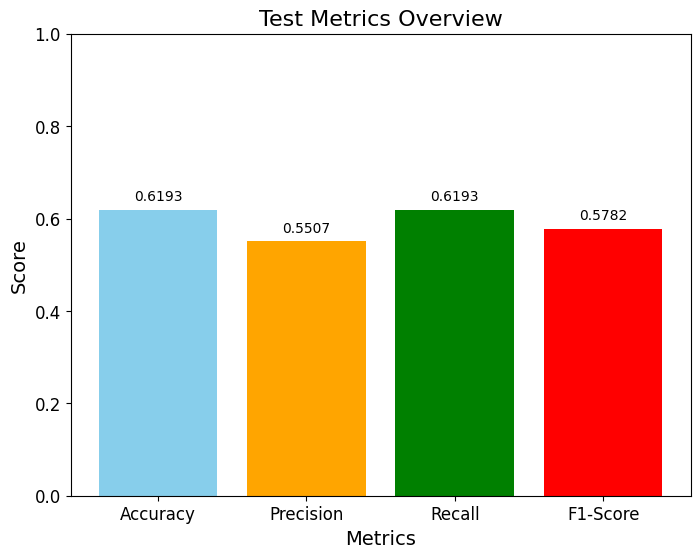

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Plot function for metrics
def plot_metrics(metrics, metric_names, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(metric_names, metrics, color=['skyblue', 'orange', 'green', 'red'])

    # Add value annotations on bars
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                f"{bar.get_height():.4f}", ha='center', fontsize=10)

    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_xlabel("Metrics", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# After testing, plot the metrics
#print("\nEvaluating on Test Set")
#test_accuracy, test_precision, test_recall, test_f1 = test_model(model, test_loader, device)

# Metrics and their names
metrics = [test_accuracy, test_precision, test_recall, test_f1]
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Plot the test results
plot_metrics(metrics, metric_names, title="Test Metrics Overview")


# **Metrics by class**

In [41]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import torch
import numpy as np  # Add numpy import for array operations

def test_model_and_store_predictions(model, data_loader, device, id2label, output_csv="predictions.csv"):
    model.eval()
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Testing"):
            # Move batch to GPU/CPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            document_id = batch["document_id"]
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Collect predictions and true labels
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(document_id.cpu().numpy())  # Save the unique identifier for each record

    # Create DataFrame to store predictions along with the actual data
    predictions_df = pd.DataFrame({
        "document_id": all_ids,
        "True_Label": all_labels,
        "Pred_Label": all_preds
    })

    # Save to CSV
    predictions_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)

    # Per-class accuracy
    per_class_accuracy = {}
    for class_idx in range(len(id2label)):
        # True positives for this class
        true_positive = np.sum((np.array(all_preds) == class_idx) & (np.array(all_labels) == class_idx))
        # Total instances of this class in the dataset
        total_class_instances = np.sum(np.array(all_labels) == class_idx)
        per_class_accuracy[id2label[class_idx]] = true_positive / total_class_instances if total_class_instances > 0 else 0.0

    # Prepare and print results
    print("\nTest Results")
    print("-" * 30)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Print metrics for each class
    class_metrics = {}
    for idx, label in id2label.items():
        class_metrics[label] = {
            "Accuracy": per_class_accuracy[label],
            "Precision": precision[idx],
            "Recall": recall[idx],
            "F1-Score": f1[idx],
        }
        print(f"\nClass: {label}")
        print(f"  Accuracy: {per_class_accuracy[label]:.4f}")
        print(f"  Precision: {precision[idx]:.4f}")
        print(f"  Recall: {recall[idx]:.4f}")
        print(f"  F1-Score: {f1[idx]:.4f}")

    return accuracy, class_metrics


# Example usage:
# Call the test function and store the predictions
print("\nEvaluating on Test Set")
test_accuracy, test_class_metrics = test_model_and_store_predictions(model, test_loader, device, id2label)

# After saving predictions to CSV, you can use pandas to compute metrics or analyze the data
# Example: Loading the CSV and computing overall metrics
predictions_df = pd.read_csv("predictions.csv")
accuracy = accuracy_score(predictions_df["True_Label"], predictions_df["Pred_Label"])
precision, recall, f1, support = precision_recall_fscore_support(predictions_df["True_Label"], predictions_df["Pred_Label"], average=None)

# Print metrics from CSV
print("\nTest Results from CSV")
print(f"Overall Accuracy: {accuracy:.4f}")
for idx, label in id2label.items():
    print(f"\nClass: {label}")
    print(f"  Precision: {precision[idx]:.4f}")
    print(f"  Recall: {recall[idx]:.4f}")
    print(f"  F1-Score: {f1[idx]:.4f}")



Evaluating on Test Set


Testing:   0%|          | 0/1468 [00:00<?, ?it/s]c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Testing: 100%|██████████| 1468/1468 [11:43<00:00,  2.09it/s]


Predictions saved to predictions.csv

Test Results
------------------------------
Overall Accuracy: 0.6193

Class: UNDEFINED
  Accuracy: 0.5801
  Precision: 0.6498
  Recall: 0.5801
  F1-Score: 0.6130

Class: LEFT
  Accuracy: 0.6846
  Precision: 0.6407
  Recall: 0.6846
  F1-Score: 0.6619

Class: RIGHT
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Class: CENTER
  Accuracy: 0.8185
  Precision: 0.5880
  Recall: 0.8185
  F1-Score: 0.6844

Test Results from CSV
Overall Accuracy: 0.6193

Class: UNDEFINED
  Precision: 0.6498
  Recall: 0.5801
  F1-Score: 0.6130

Class: LEFT
  Precision: 0.6407
  Recall: 0.6846
  F1-Score: 0.6619

Class: RIGHT
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Class: CENTER
  Precision: 0.5880
  Recall: 0.8185
  F1-Score: 0.6844


c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ALEJANDRO\Documents\7. DUKE\1. ECE 684 - NLP\Assignments\Final Project\venv_lda_implementation\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
preds = pd.read_csv("predictions.csv")
preds.groupby("True_Label").count()

# Group by True_Label and Pred_Label to count occurrences of each combination
group_counts = preds.groupby(['True_Label', 'Pred_Label']).size().reset_index(name='Count')

# Print the counts of matching labels
matching_counts = group_counts[group_counts['True_Label'] == group_counts['Pred_Label']]
print(matching_counts)


    True_Label  Pred_Label  Count
0          0.0           0   2256
4          1.0           1   2974
11         3.0           3   3856


In [48]:
preds[preds['True_Label']==2].head(100)

,document_id,True_Label,Pred_Label
16,4348226,2.0,1
26,4604594,2.0,1
40,4585051,2.0,3
57,4291624,2.0,3
68,4316093,2.0,1
...,...,...,...
830,4359340,2.0,0
835,4287042,2.0,1
846,4349037,2.0,3
852,4627595,2.0,3


In [42]:
# Access and process per-class metrics if needed
for class_name, metrics in test_class_metrics.items():
    print(f"\nMetrics for {class_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Metrics for UNDEFINED:
Accuracy: 0.5801
Precision: 0.6498
Recall: 0.5801
F1-Score: 0.6130

Metrics for LEFT:
Accuracy: 0.6846
Precision: 0.6407
Recall: 0.6846
F1-Score: 0.6619

Metrics for RIGHT:
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Metrics for CENTER:
Accuracy: 0.8185
Precision: 0.5880
Recall: 0.8185
F1-Score: 0.6844
